In [264]:
import pandas as pd
import numpy as np
import random
from os import path, mkdir
from IPython.display import display, HTML
import matplotlib.pyplot as plt

In [265]:
dataset = pd.read_csv('final.csv')
dirPlots = '../Plots'
dataset

,Unnamed: 0,Name,gender,Age,StudentID,ethnicity,parental education,lunch,prep course,math score,reading score,writing score
0,0,Mark Dodd,female,22,10000,group B,bachelor's degree,standard,none,72,72,74
1,1,Tony Meola,female,26,10001,group C,some college,standard,completed,69,90,88
2,2,Mark Dougherty,female,26,10002,group B,master's degree,standard,none,90,95,93
3,3,Jorge Campos,male,22,10003,group A,associate's degree,free/reduced,none,47,57,44
4,4,Garth Lagerwey,male,20,10004,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,Luis Robles,female,23,10995,group E,master's degree,standard,completed,88,99,95
996,996,Zack Steffen,male,25,10996,group C,high school,free/reduced,none,62,55,55
997,997,Bobby Shuttleworth,female,22,10997,group C,high school,free/reduced,completed,59,71,65
998,998,Stefan Frei,female,22,10998,group D,some college,standard,completed,68,78,77


In [266]:
def saveFig(fig,name):
    if not path.exists(dirPlots):
        mkdir(dirPlots)
    fig.savefig(dirPlots+"/"+name+".png",facecolor=fig.get_facecolor())

EXERCISE 2.1 - Study the sensitivity of the analysis implemented during the preparation phase.

In [267]:
def avgSensitivity(attribute):
    genAvg = np.average(attribute)
    dataArr = np.array(attribute)
    
    avgs = []
    for i in range(len(dataArr)):
        newAvg = np.average(np.delete(dataArr,i))
        avgs.append(newAvg)
    
    firstFlag = 0
    for avg in avgs:
        if firstFlag == 0:
            maxDiff = abs(genAvg - avg)
            firstFlag = 1
        else:
            maxi = abs(genAvg - avg)
            if maxi > maxDiff:
                maxDiff = maxi
    return maxDiff

In [268]:
def stdSensitivity(attribute):
    genAvg = np.std(attribute)
    dataArr = np.array(attribute)
    
    stds = []
    for i in range(len(dataArr)):   
        newStd = np.std(np.delete(dataArr,i))
        stds.append(newStd)
    
    firstFlag = 0
    for avg in stds:
        if firstFlag == 0:
            maxDiff = abs(genAvg - avg)
            firstFlag = 1
        else:
            maxi = abs(genAvg - avg)
            if maxi > maxDiff:
                maxDiff = maxi
    return maxDiff

In [269]:
maxDiffMathScoreAvg = avgSensitivity(dataset["math score"])
maxDiffMathScoreStd = stdSensitivity(dataset["math score"])

maxDiffReadScoreAvg = avgSensitivity(dataset["reading score"])
maxDiffReadScoreStd = stdSensitivity(dataset["reading score"])

maxDiffWriteScoreAvg = avgSensitivity(dataset["writing score"])
maxDiffWriteScoreStd = stdSensitivity(dataset["writing score"])

originalDiff = [maxDiffMathScoreAvg,maxDiffMathScoreStd,
                maxDiffReadScoreAvg,maxDiffReadScoreStd,
                maxDiffWriteScoreAvg, maxDiffWriteScoreStd]

sensitivityData = pd.DataFrame(index = ["original","0.01","0.2","ln(2)","ln(3)"],
                                columns = ["math score avg","math score std", "reading score avg","reading score std","writing score avg","writing score std"])

sensitivityData.loc["original"] = originalDiff

sensitivityData

,math score avg,math score std,reading score avg,reading score std,writing score avg,writing score std
original,0.066155,0.137424,0.052221,0.08639,0.058112,0.103927
0.01,NaN,NaN,NaN,NaN,NaN,NaN
0.2,NaN,NaN,NaN,NaN,NaN,NaN
ln(2),NaN,NaN,NaN,NaN,NaN,NaN
ln(3),NaN,NaN,NaN,NaN,NaN,NaN


EXERCISE 2.2 - Implement a differential privacy mechanism to add to the analyses.

In [270]:
def diffPriv(dataset,columnName,querySensitivity,epsilon):
    col = np.array(dataset[columnName])
    dataset.drop(columns=[columnName])
    laplaceVal = np.random.laplace(0,querySensitivity/epsilon,len(col))
    for i in range(len(col)):
        col[i] += laplaceVal[i]
    dataset[columnName] = col

Exercise 2.3 - Execute the analysis with the implemented differential privacy.

In [271]:
epsilons = {'0.01':0.01,'0.2':0.2,'ln(2)': np.log(2),'ln(3)': np.log(3)}
attributes = ['math score','reading score','writing score']

for attr in attributes:
    for key,value in epsilons.items():
        attributeDataAvg = dataset.copy()
        attributeDataStd = dataset.copy()

        diffPriv(attributeDataAvg,attr,sensitivityData.loc["original"][attr + ' avg'],value)
        diffPriv(attributeDataStd,attr,sensitivityData.loc["original"][attr + ' std'],value)

        newSensivityAvg = avgSensitivity(attributeDataAvg[attr])
        newSensivityStd = stdSensitivity(attributeDataStd[attr])
        sensitivityData.loc[key][attr +' avg'] = newSensivityAvg
        sensitivityData.loc[key][attr +' std'] = newSensivityStd

sensitivityData


,math score avg,math score std,reading score avg,reading score std,writing score avg,writing score std
original,0.066155,0.137424,0.052221,0.08639,0.058112,0.103927
0.01,0.066588,0.288445,0.080431,0.100396,0.067748,0.09886
0.2,0.065617,0.148003,0.051701,0.084535,0.058607,0.106131
ln(2),0.065656,0.135408,0.052729,0.084201,0.05861,0.105871
ln(3),0.06566,0.135064,0.051718,0.084516,0.057613,0.105988


EXERCISE 2.4 - Analyze the results and compare with the results obtained in the other phases.

In [272]:
def plotSensAnalysis(x,title, avg,std,figName):
    plt.figure(figsize=(12, 7))

    plt.grid(True)
    plt.title("Sensitivity of " + title, fontsize='x-large')
    plt.ylabel("Sensitivity", fontsize='x-large')
    plt.xlabel("Epsilon value", fontsize='x-large')
    
    plt.scatter(x, avg, color='blue')
    plt.scatter(x, std, color='red')
    
    plt.plot(x, avg, label="Evolution of avg (original, 0.01, 0.2, ln(2), ln(3))", color='blue')
    plt.plot(x, std, label="Evolution of std (original, 0.01, 0.2, ln(2), ln(3))", color='red')
    
    plt.legend()
    fig = plt.gcf()
    saveFig(fig,figName)
    plt.show()

Pelo o que se observa nos gráficos, quando o epsilon toma valores baixos os valores de avg(average) e std(standard deviation), retornados pela respetiva função de cálculo de sensibilidade, aumentam. No entanto a variaçáo dos valores de avg nos gráficos dos resultados do teste de Matemática e dos resultados do teste de ler é irrisória.

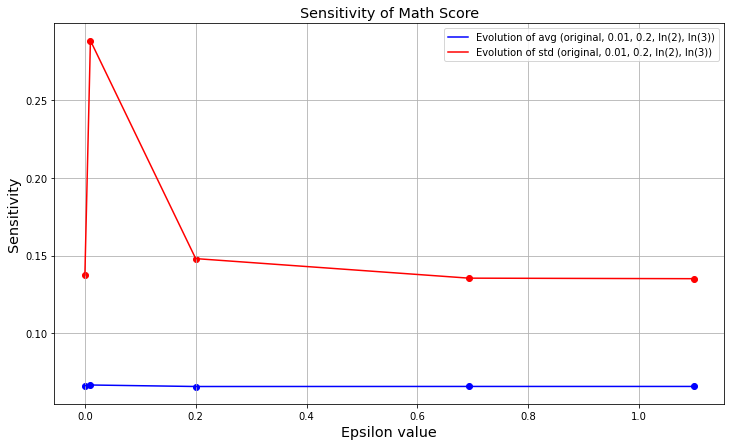

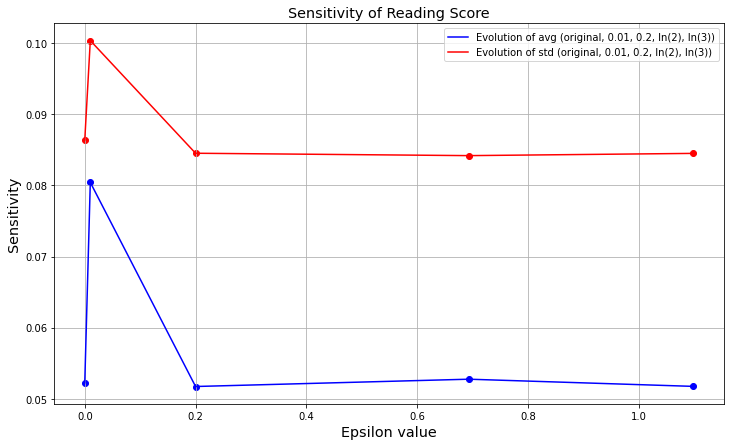

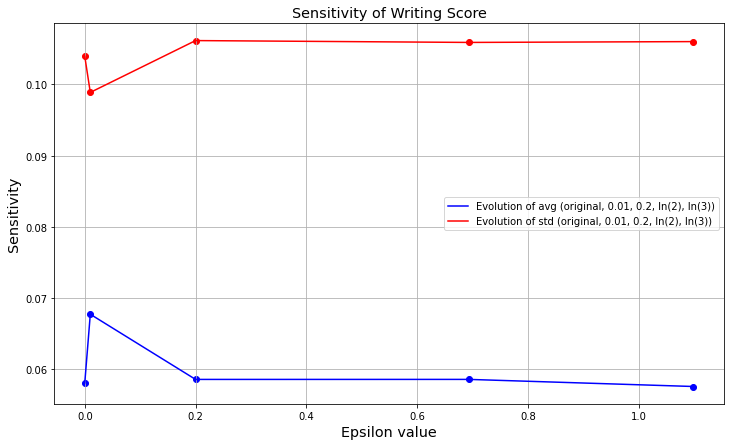

In [273]:
x = [0,0.01,0.2,np.log(2),np.log(3)]
plotSensAnalysis(x,"Math Score",sensitivityData['math score avg'],sensitivityData['math score std'],'Sensivity_MathScore')
plotSensAnalysis(x,"Reading Score",sensitivityData['reading score avg'],sensitivityData['reading score std'],'Sensivity_ReadingScore')
plotSensAnalysis(x,"Writing Score",sensitivityData['writing score avg'],sensitivityData['writing score std'],'Sensivity_WritingScore')

In [274]:
def plotGroupAnalysis(title,xLabel,yLabel,x,plotDatas,figName,rotationAx = None):
    plt.figure()
    plt.subplots(2, 2, figsize=(22, 15))

    plt.subplot(2, 2, 1)
    plt.grid(True)
    plt.title(title)
    plt.ylabel(yLabel)
    plt.plot(x, plotDatas['original'], color='red')
    plt.scatter(x, plotDatas['original'], color='red', label="Original values")
    plt.plot(x, plotDatas['0.01'], color='green')
    plt.scatter(x,plotDatas['0.01'], label="Epsilon 0.01", color='green')
    if rotationAx is not None:
        plt.xticks(rotation = rotationAx)
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.grid(True)
    plt.title("Comparison between mean values of income per year grouped by age")
    plt.plot(x, plotDatas['original'], color='red')
    plt.scatter(x, plotDatas['original'], color='red', label="Original values")
    plt.plot(x, plotDatas['0.2'], color='yellow')
    plt.scatter(x, plotDatas['0.2'], label="Epsilon 0.2", color='yellow')
    if rotationAx is not None:
        plt.xticks(rotation = rotationAx)
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.grid(True)
    plt.ylabel(yLabel)
    plt.xlabel(xLabel)
    if rotationAx is not None:
        plt.xticks(rotation = rotationAx)
    plt.plot(x, plotDatas['original'], color='red')
    plt.scatter(x, plotDatas['original'], color='red', label="Original values")
    plt.plot(x, plotDatas['ln(2)'], color='blue')
    plt.scatter(x, plotDatas['ln(2)'], label="Epsilon ln(2)", color='blue')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.grid(True)
    plt.xlabel(xLabel)
    plt.plot(x, plotDatas['original'], color='red')
    plt.scatter(x, plotDatas['original'], color='red', label="Original values")
    plt.plot(x, plotDatas['ln(3)'], color='orange')
    plt.scatter(x,  plotDatas['ln(3)'], label="Epsilon ln(3)", color='orange')
    if rotationAx is not None:
        plt.xticks(rotation = rotationAx)
    plt.legend()
    fig = plt.gcf()
    saveFig(fig,figName)
    plt.show()

In [275]:
def groupDiffPriv(group,queryType):
    if queryType == 'avg':
        datasetGroup = dataset.groupby(group).mean()[['math score','reading score','writing score']]
    else:
        datasetGroup = dataset.groupby(group).std()[['math score','reading score','writing score']]
    
    dataset0_0_1 = datasetGroup.copy()
    dataset0_2 = datasetGroup.copy()
    datasetln_2  = datasetGroup.copy()
    datasetln_3 = datasetGroup.copy()
    
    diffPriv(dataset0_0_1,'math score',sensitivityData.loc['0.01']['math score ' + queryType],0.01)
    diffPriv(dataset0_2,'math score',sensitivityData.loc['0.2']['math score ' + queryType],0.2)
    diffPriv(datasetln_2,'math score',sensitivityData.loc['ln(2)']['math score ' + queryType],np.log(2))
    diffPriv(datasetln_3,'math score',sensitivityData.loc['ln(3)']['math score ' + queryType],np.log(3))


    diffPriv(dataset0_0_1,'reading score',sensitivityData.loc['0.01']['reading score '+queryType],0.01)
    diffPriv(dataset0_2, 'reading score',sensitivityData.loc['0.2']['reading score '+queryType],0.2)
    diffPriv(datasetln_2, 'reading score',sensitivityData.loc['ln(2)']['reading score '+queryType],np.log(2))
    diffPriv(datasetln_3, 'reading score',sensitivityData.loc['ln(3)']['reading score '+queryType],np.log(3))

    diffPriv(dataset0_0_1,'writing score',sensitivityData.loc['0.01']['writing score '+queryType],0.01)
    diffPriv(dataset0_2,'writing score',sensitivityData.loc['0.2']['writing score '+queryType],0.2)
    diffPriv(datasetln_2,'writing score',sensitivityData.loc['ln(2)']['writing score '+ queryType],np.log(2))
    diffPriv(datasetln_3,'writing score',sensitivityData.loc['ln(3)']['writing score '+queryType],np.log(3))
    

    if queryType == 'avg':
        dataset0_0_1 = dataset0_0_1.groupby(group).mean()[['math score','reading score','writing score']]
        dataset0_2 = dataset0_2.groupby(group).mean()[['math score','reading score','writing score']]
        datasetln_2 = datasetln_2.groupby(group).mean()[['math score','reading score','writing score']]
        datasetln_3 = datasetln_3.groupby(group).mean()[['math score','reading score','writing score']]
    else:
        dataset0_0_1 = dataset0_0_1.groupby(group).std()[['math score','reading score','writing score']]

        dataset0_2 = dataset0_2.groupby(group).std()[['math score','reading score','writing score']]
        datasetln_2 = datasetln_2.groupby(group).std()[['math score','reading score','writing score']]
        datasetln_3 = datasetln_3.groupby(group).std()[['math score','reading score','writing score']]
    
    return datasetGroup,dataset0_0_1,dataset0_2,datasetln_2,datasetln_3

Os gráficos que se seguem comparam os valores orginais com os valores alterados pela a função diffPriv (implementação do mecanismo Differential Privacy)

    - Observa-se que com o epsilon = 0.01 que a diferença entre os valores orignais e valores alterados é notória
    - Tendo epsilon = 0.2 a diferença ainda se nota no entanto é menor comparada ao caso anterior
    - Com epsilon = ln(2) ou epsilon = ln(3) a diferença é mínima

Este padrão de conclusões mantém-se ao longo dos gráficos

In [276]:
group = 'Age'
xLabel = group
x = np.sort(dataset[group].unique())
datasetAvgAge,datasetAvgAge0_0_1,datasetAvgAge0_2,datasetAvgAgeln_2,datasetAvgAgeln_3 = groupDiffPriv(group,'avg')

<Figure size 432x288 with 0 Axes>

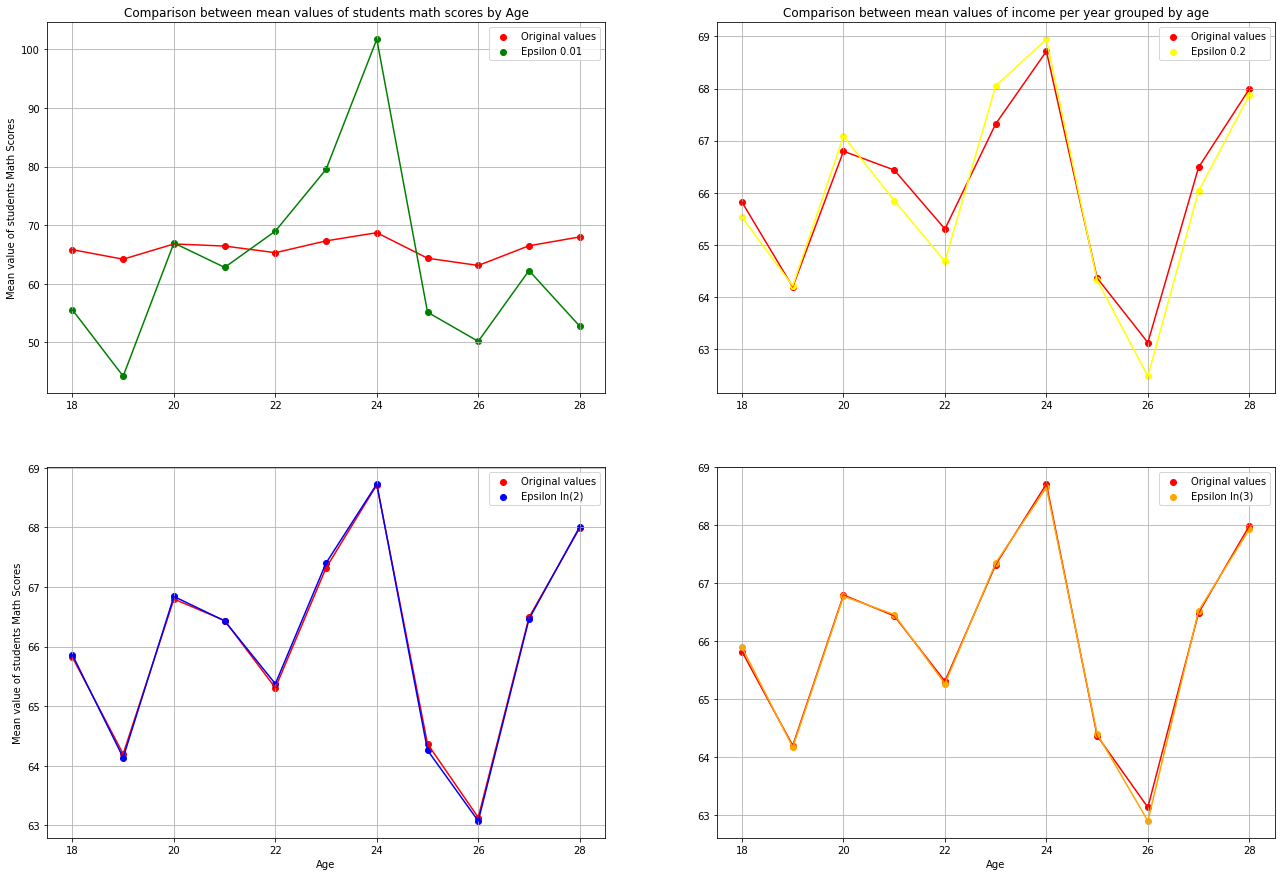

In [277]:
att = 'math score'

plotDatas = {'original': datasetAvgAge[att],'0.01': datasetAvgAge0_0_1[att],
                '0.2':datasetAvgAge0_2[att],'ln(2)':datasetAvgAgeln_2[att],'ln(3)':datasetAvgAgeln_3[att]}

yLabel = "Mean value of students Math Scores"
title = "Comparison between mean values of students math scores by " + group

plotGroupAnalysis(title,xLabel,yLabel,x, plotDatas,'diffPriv'+att+' '+ group)



<Figure size 432x288 with 0 Axes>

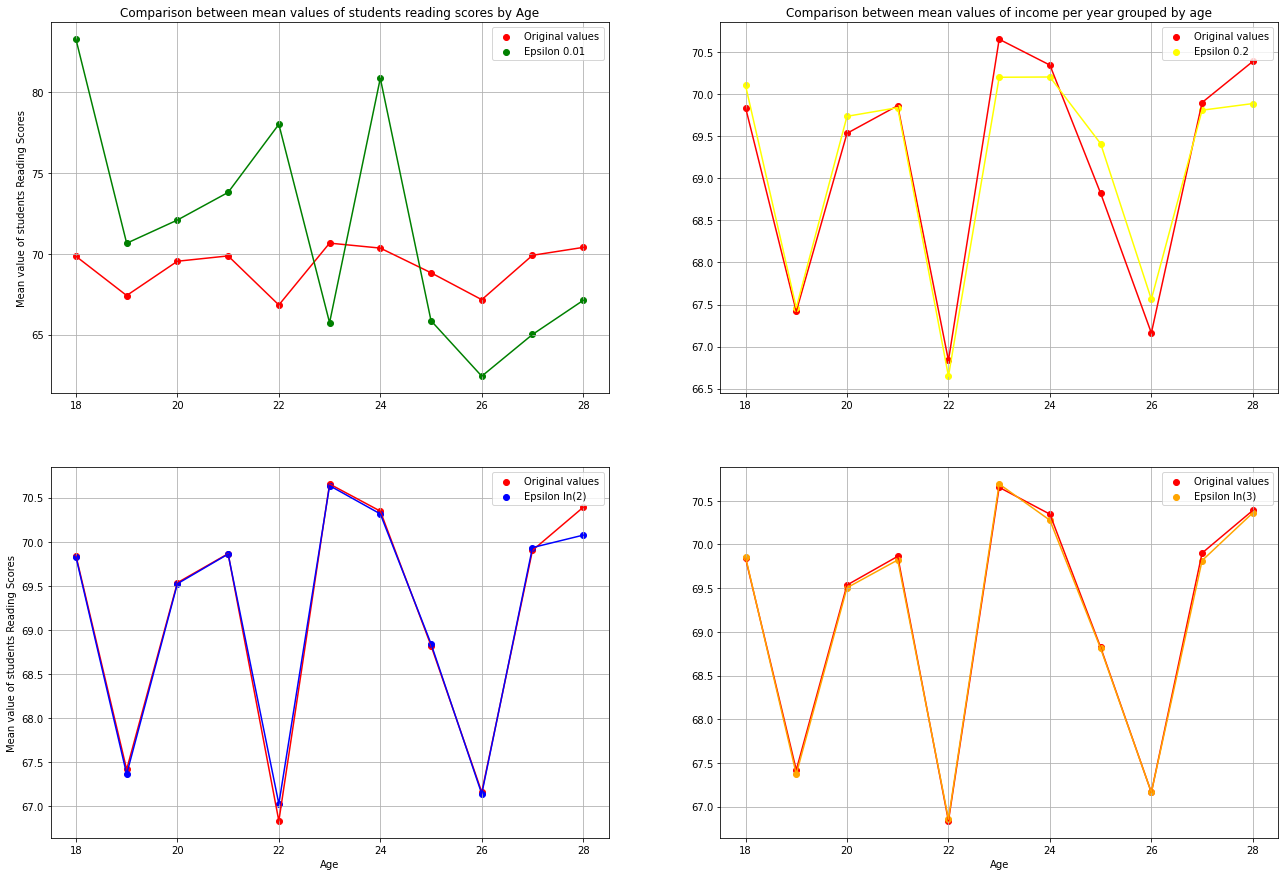

In [278]:
att = 'reading score'

plotDatas = {'original': datasetAvgAge[att],'0.01': datasetAvgAge0_0_1[att],
                '0.2':datasetAvgAge0_2[att],'ln(2)':datasetAvgAgeln_2[att],'ln(3)':datasetAvgAgeln_3[att]}

yLabel = "Mean value of students Reading Scores"
title = "Comparison between mean values of students reading scores by " + group

plotGroupAnalysis(title,xLabel,yLabel,x, plotDatas,'diffPriv'+att+' '+ group)


<Figure size 432x288 with 0 Axes>

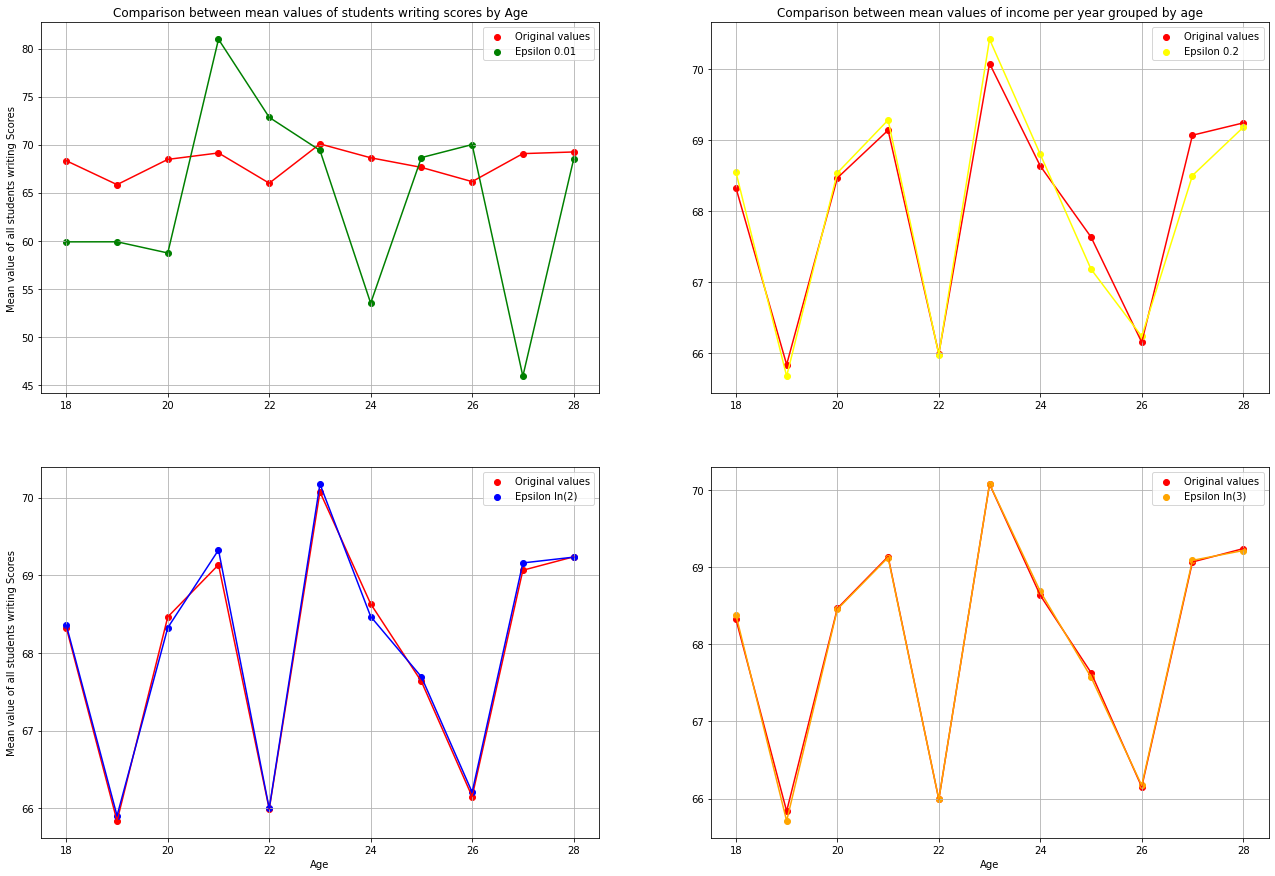

In [279]:
att = 'writing score'

plotDatas = {'original': datasetAvgAge[att],'0.01': datasetAvgAge0_0_1[att],
                '0.2':datasetAvgAge0_2[att],'ln(2)':datasetAvgAgeln_2[att],'ln(3)':datasetAvgAgeln_3[att]}

yLabel = "Mean value of all students writing Scores"
title = "Comparison between mean values of students writing scores by " + group

plotGroupAnalysis(title,xLabel,yLabel,x, plotDatas,'diffPriv'+att+' '+ group)


In [280]:
group = 'ethnicity'
xLabel = group
x = np.sort(dataset[group].unique())
datasetAvgAge,datasetAvgAge0_0_1,datasetAvgAge0_2,datasetAvgAgeln_2,datasetAvgAgeln_3 = groupDiffPriv(group,'avg')

<Figure size 432x288 with 0 Axes>

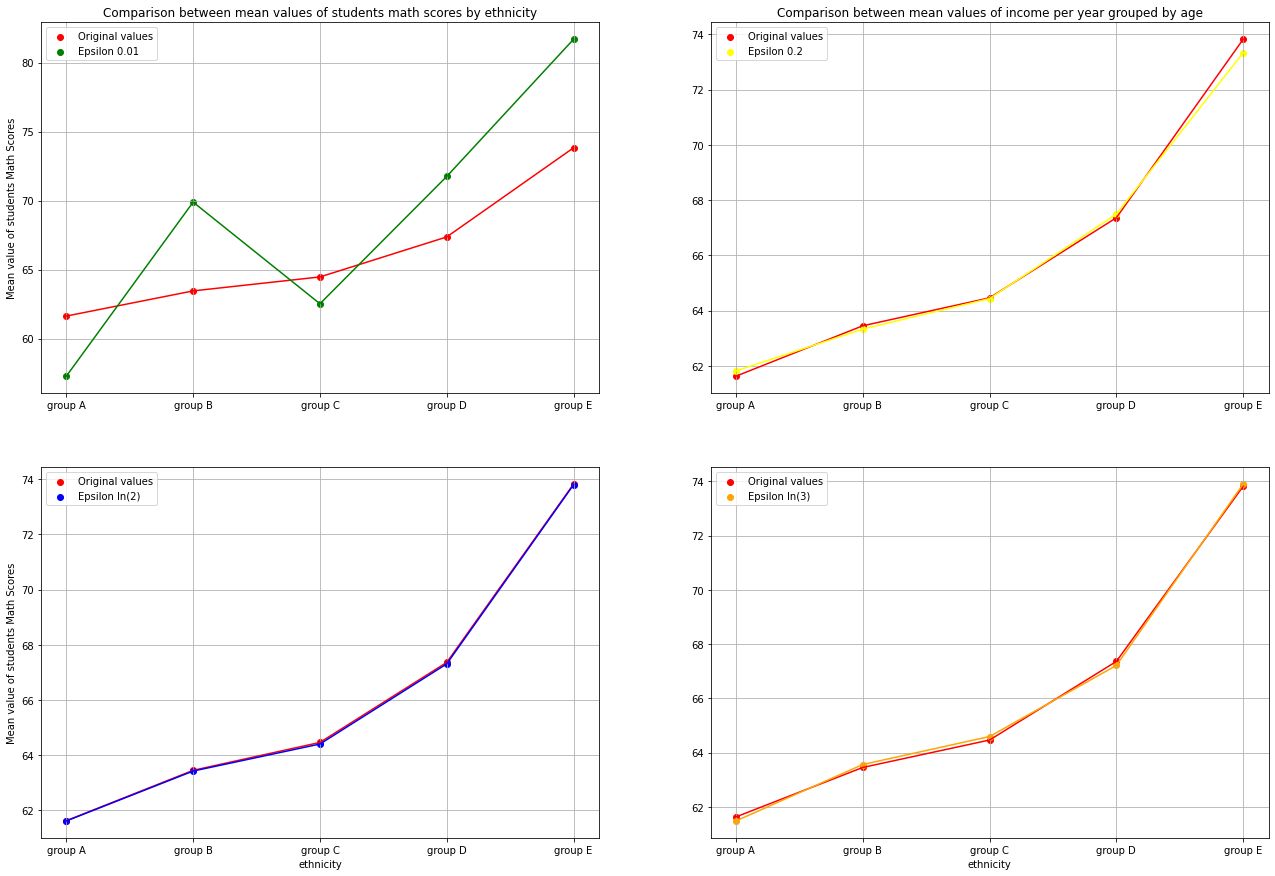

In [281]:
att = 'math score'

plotDatas = {'original': datasetAvgAge[att],'0.01': datasetAvgAge0_0_1[att],
                '0.2':datasetAvgAge0_2[att],'ln(2)':datasetAvgAgeln_2[att],'ln(3)':datasetAvgAgeln_3[att]}

yLabel = "Mean value of students Math Scores"
title = "Comparison between mean values of students math scores by " + group

plotGroupAnalysis(title,xLabel,yLabel,x, plotDatas,'diffPriv'+att+' '+ group)


<Figure size 432x288 with 0 Axes>

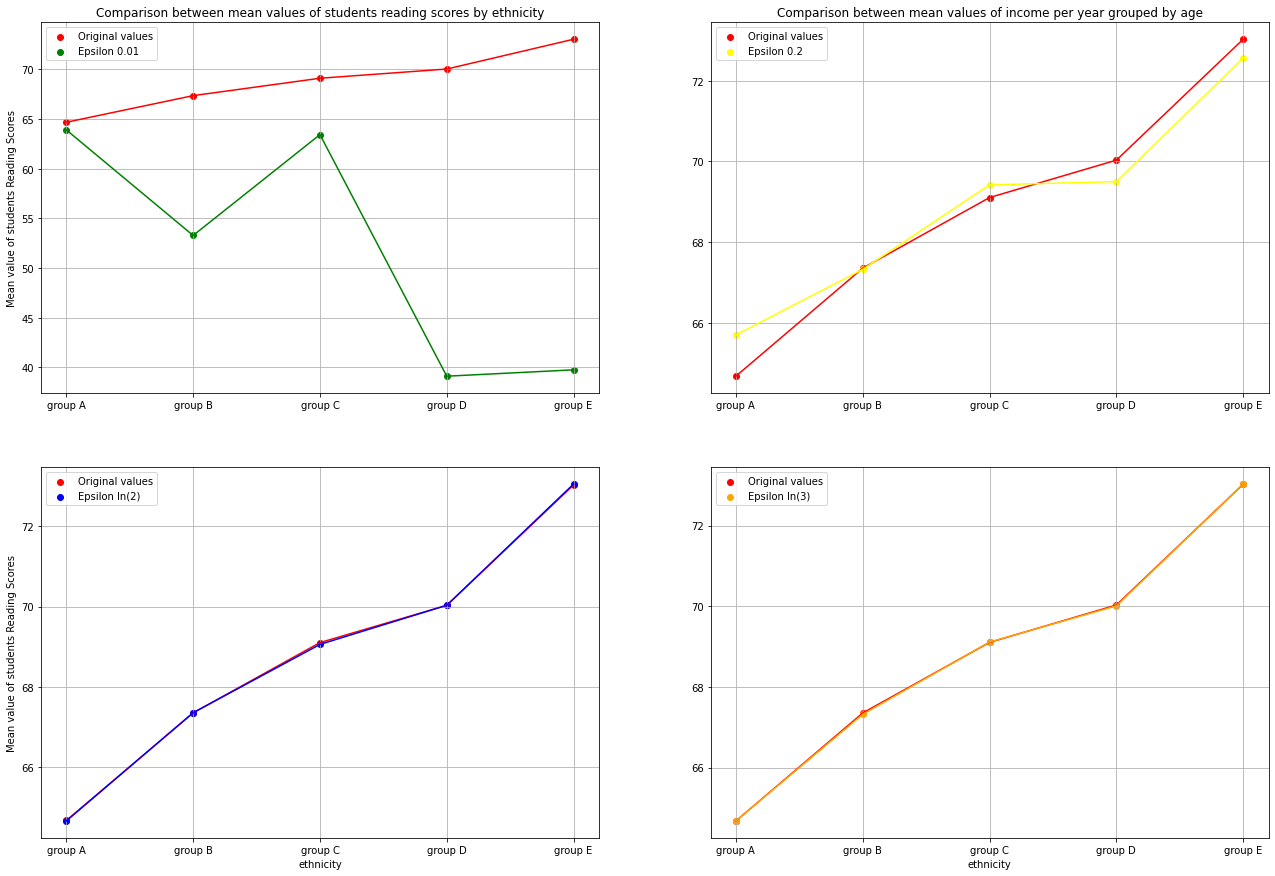

In [282]:
att = 'reading score'

plotDatas = {'original': datasetAvgAge[att],'0.01': datasetAvgAge0_0_1[att],
                '0.2':datasetAvgAge0_2[att],'ln(2)':datasetAvgAgeln_2[att],'ln(3)':datasetAvgAgeln_3[att]}

yLabel = "Mean value of students Reading Scores"
title = "Comparison between mean values of students reading scores by " + group

plotGroupAnalysis(title,xLabel,yLabel,x, plotDatas,'diffPriv'+att+' '+ group)


<Figure size 432x288 with 0 Axes>

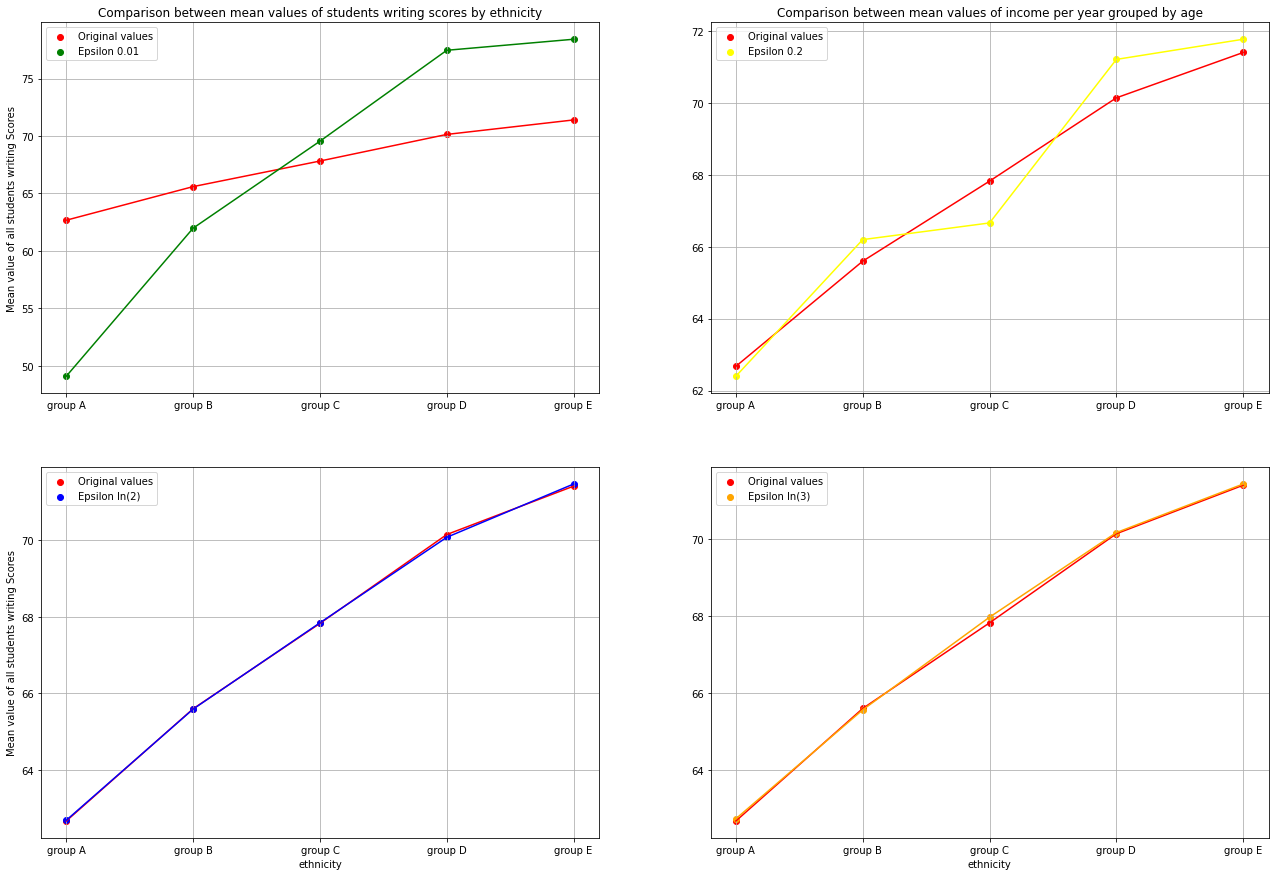

In [283]:
att = 'writing score'

plotDatas = {'original': datasetAvgAge[att],'0.01': datasetAvgAge0_0_1[att],
                '0.2':datasetAvgAge0_2[att],'ln(2)':datasetAvgAgeln_2[att],'ln(3)':datasetAvgAgeln_3[att]}

yLabel = "Mean value of all students writing Scores"
title = "Comparison between mean values of students writing scores by " + group

plotGroupAnalysis(title,xLabel,yLabel,x, plotDatas,'diffPriv'+att+' '+ group)


In [284]:
group = 'parental education'
xLabel = group
x = np.sort(dataset[group].unique())
datasetAvgAge,datasetAvgAge0_0_1,datasetAvgAge0_2,datasetAvgAgeln_2,datasetAvgAgeln_3 = groupDiffPriv(group,'avg')

<Figure size 432x288 with 0 Axes>

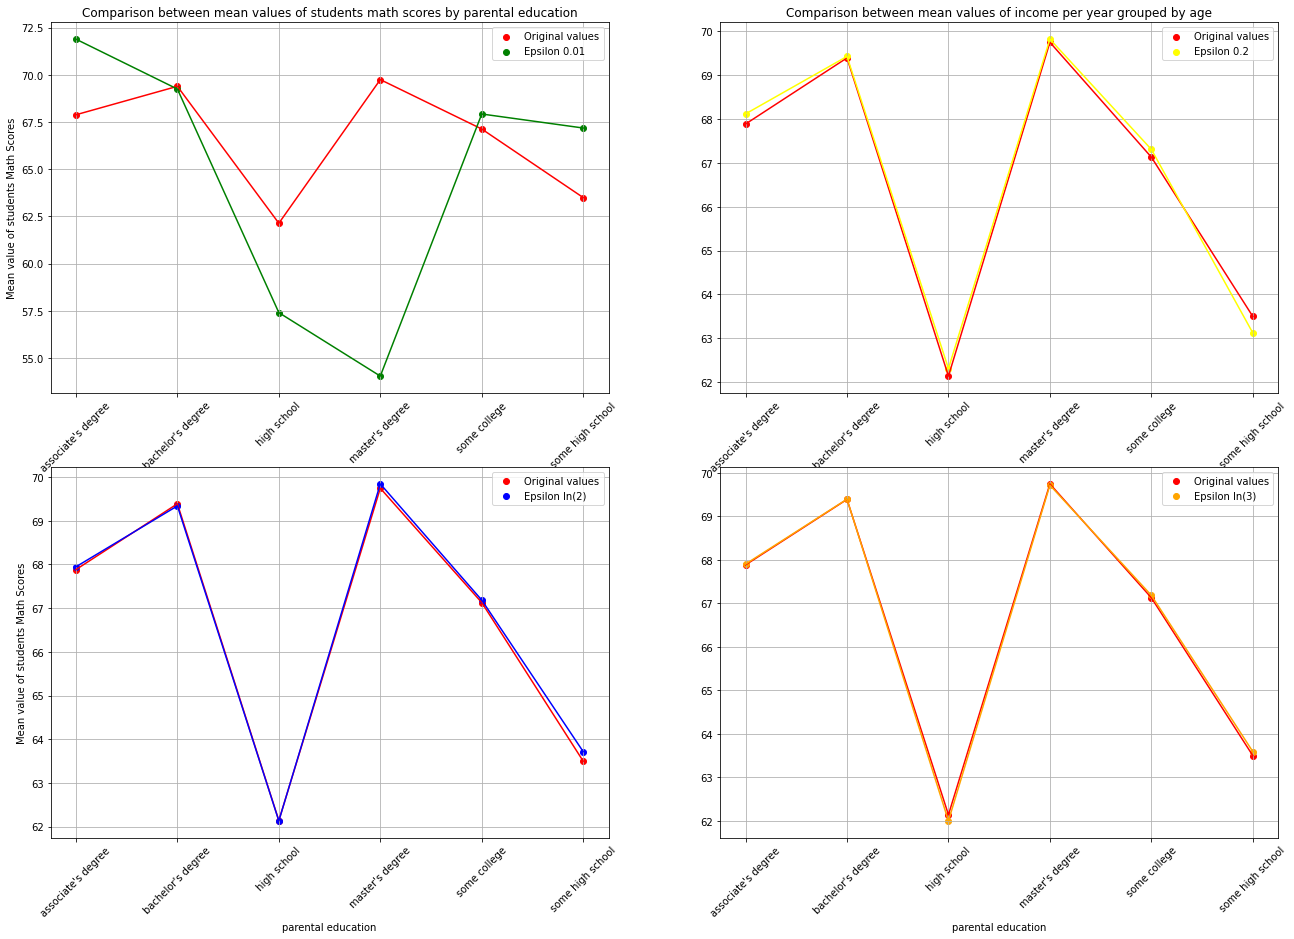

In [285]:
att = 'math score'

plotDatas = {'original': datasetAvgAge[att],'0.01': datasetAvgAge0_0_1[att],
                '0.2':datasetAvgAge0_2[att],'ln(2)':datasetAvgAgeln_2[att],'ln(3)':datasetAvgAgeln_3[att]}

yLabel = "Mean value of students Math Scores"
title = "Comparison between mean values of students math scores by " + group

plotGroupAnalysis(title,xLabel,yLabel,x, plotDatas,'diffPriv'+att+' '+ group,45)


<Figure size 432x288 with 0 Axes>

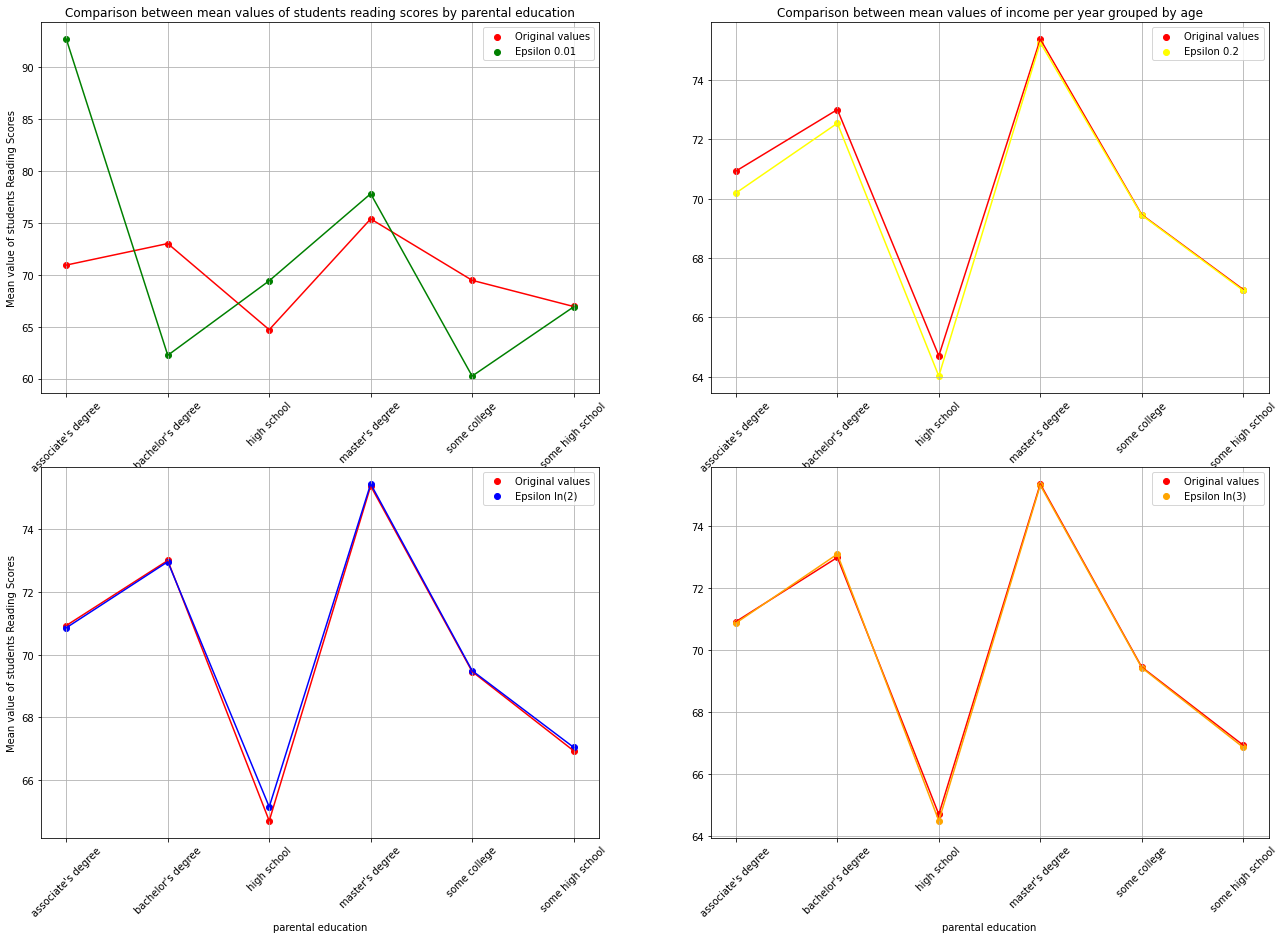

In [286]:
att = 'reading score'

plotDatas = {'original': datasetAvgAge[att],'0.01': datasetAvgAge0_0_1[att],
                '0.2':datasetAvgAge0_2[att],'ln(2)':datasetAvgAgeln_2[att],'ln(3)':datasetAvgAgeln_3[att]}

yLabel = "Mean value of students Reading Scores"
title = "Comparison between mean values of students reading scores by " + group

plotGroupAnalysis(title,xLabel,yLabel,x, plotDatas,'diffPriv'+att+' '+ group,45)


<Figure size 432x288 with 0 Axes>

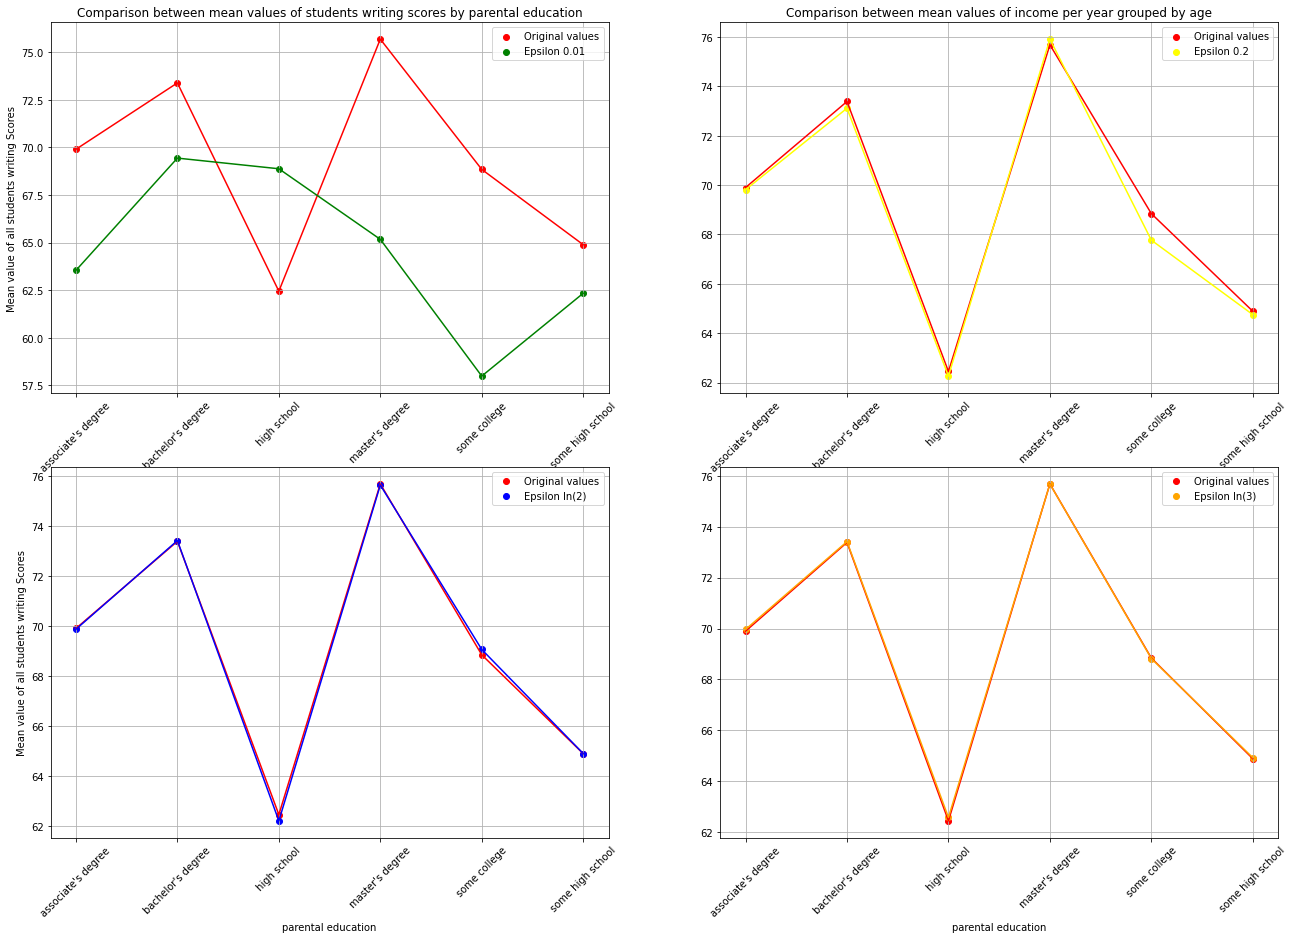

In [287]:
att = 'writing score'

plotDatas = {'original': datasetAvgAge[att],'0.01': datasetAvgAge0_0_1[att],
                '0.2':datasetAvgAge0_2[att],'ln(2)':datasetAvgAgeln_2[att],'ln(3)':datasetAvgAgeln_3[att]}

yLabel = "Mean value of all students writing Scores"
title = "Comparison between mean values of students writing scores by " + group

plotGroupAnalysis(title,xLabel,yLabel,x, plotDatas,'diffPriv'+att+' '+ group,45)


In [288]:
def queryVariation(numQueries,group,groupTypes,queryType,attEval):

    if queryType == 'avg':
        datasetGroup = dataset.groupby(group).mean()[[attEval]]
    else:
        datasetGroup = dataset.groupby(group).std()[[attEval]]

    queries = range(numQueries+1)

    group0_0_1 = pd.DataFrame(columns = groupTypes,index = queries)
    group0_2 = pd.DataFrame(columns = groupTypes,index = queries)
    groupln_2 = pd.DataFrame(columns = groupTypes,index = queries)
    groupln_3 = pd.DataFrame(columns = groupTypes,index = queries)
 
    for t in groupTypes:
        group0_0_1.iloc[0][t] = datasetGroup.loc[t][attEval]
        group0_2.iloc[0][t] = datasetGroup.loc[t][attEval]
        groupln_2.iloc[0][t] = datasetGroup.loc[t][attEval]
        groupln_3.iloc[0][t] = datasetGroup.loc[t][attEval]

    for i in range(1,numQueries+1):

        data0_0_1 = dataset.copy()
        data0_2 = dataset.copy()
        dataln_2 = dataset.copy()
        dataln_3 = dataset.copy()

        diffPriv(data0_0_1,attEval,sensitivityData.loc['original'][attEval + ' ' + queryType],epsilon = 0.01)
        diffPriv(data0_2,attEval,sensitivityData.loc['original'][attEval + ' ' + queryType],epsilon = 0.2)
        diffPriv(dataln_2,attEval,sensitivityData.loc['original'][attEval + ' ' + queryType], epsilon = np.log(2))
        diffPriv(dataln_3,attEval,sensitivityData.loc['original'][attEval + ' ' + queryType], epsilon = np.log(3))
        
        if queryType == 'avg':
            data0_0_1 = data0_0_1.groupby(group).mean()[[attEval]]
            data0_2 = data0_2.groupby(group).mean()[[attEval]]
            dataln_2 = dataln_2.groupby(group).mean()[[attEval]]
            dataln_3 = dataln_3.groupby(group).mean()[[attEval]]
        else:
            data0_0_1 = data0_0_1.groupby(group).std()[[attEval]]
            data0_2 = data0_2.groupby(group).std()[[attEval]]
            dataln_2 = dataln_2.groupby(group).std()[[attEval]]
            dataln_3 = dataln_3.groupby(group).std()[[attEval]]

        for t in groupTypes:
            group0_0_1.iloc[i][t] = data0_0_1.loc[t][attEval]
            group0_2.iloc[i][t] = data0_2.loc[t][attEval]
            groupln_2.iloc[i][t] = dataln_2.loc[t][attEval]
            groupln_3.iloc[i][t] = dataln_3.loc[t][attEval]
    
    return group0_0_1, group0_2, groupln_2,groupln_3

In [289]:
def plotQueryVariation(x,plotDatas,group,groupTypes,attr,figName):
    plt.figure()
    plt.subplots(2, 2, figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.grid(True)
    plt.title("Variation of average "+  attr + " (epsilon = 0.01)")
    plt.ylabel("Average value of " + attr)
    plt.scatter(x, plotDatas['0.01'][groupTypes[0]], color='blue', label = group+'('+groupTypes[0]+')')
    plt.scatter(x, plotDatas['0.01'][groupTypes[1]], color='red', label = group+'('+groupTypes[1]+')')
    plt.plot(x, plotDatas['0.01'][groupTypes[0]], color='blue')
    plt.plot(x, plotDatas['0.01'][groupTypes[1]], color='red')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.grid(True)
    plt.title("Variation of average "+  attr + "  (epsilon = 0.2)")
    plt.scatter(x, plotDatas['0.2'][groupTypes[0]], color='blue',  label = group+'('+groupTypes[0]+')')
    plt.scatter(x, plotDatas['0.2'][groupTypes[1]], color='red', label = group+'('+groupTypes[1]+')')
    plt.plot(x, plotDatas['0.2'][groupTypes[0]], color='blue')
    plt.plot(x, plotDatas['0.2'][groupTypes[1]], color='red')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.grid(True)
    plt.title("Variation of average "+  attr + " (epsilon = ln(2))")
    plt.ylabel("Average value of " + attr)
    plt.xlabel("Query Iteration")
    plt.scatter(x, plotDatas['ln(2)'][groupTypes[0]], color='blue', label = group+'('+groupTypes[0] +')')
    plt.scatter(x, plotDatas['ln(2)'][groupTypes[1]], color='red', label = group+'('+groupTypes[1] +')')
    plt.plot(x, plotDatas['ln(2)'][groupTypes[0]], color='blue')
    plt.plot(x, plotDatas['ln(2)'][groupTypes[1]], color='red')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.grid(True)
    plt.title("Variation of average "+  attr + " (epsilon = ln(3))")
    plt.xlabel("Query Iteration")
    plt.scatter(x, plotDatas['ln(3)'][groupTypes[0]], color='blue', label = group+'('+groupTypes[0]+')')
    plt.scatter(x, plotDatas['ln(3)'][groupTypes[1]], color='red', label = group+'('+groupTypes[1]+')')
    plt.plot(x, plotDatas['ln(3)'][groupTypes[0]], color='blue')
    plt.plot(x, plotDatas['ln(3)'][groupTypes[1]], color='red')
    
    plt.legend()
    fig = plt.gcf()
    saveFig(fig,figName)
    
    plt.show()

- Esta última secção de análise consiste numa query ser repetida 150 vezes, em que a cada query feita é aplicada a differencial privacy, fazendo sempre o valor da média dos resultados de teste matemática/leitura/escrita

- O primeiro valor é o valor original, como foi analisado previamente sabemos que há medida que aumentamos o valor de epsilon menor vai ser a diferença para os dados originais. Os resultados das queries tendem a aproximar-se dos originais, como podemos ver pela diferença clara entre os valores quando epsilon = 0.01 e epsilon = ln(3)
- Os resultados das queries do último do gráfico são os que têm menor diferença para os dados originais relativamente aos outros gráficos

<Figure size 432x288 with 0 Axes>

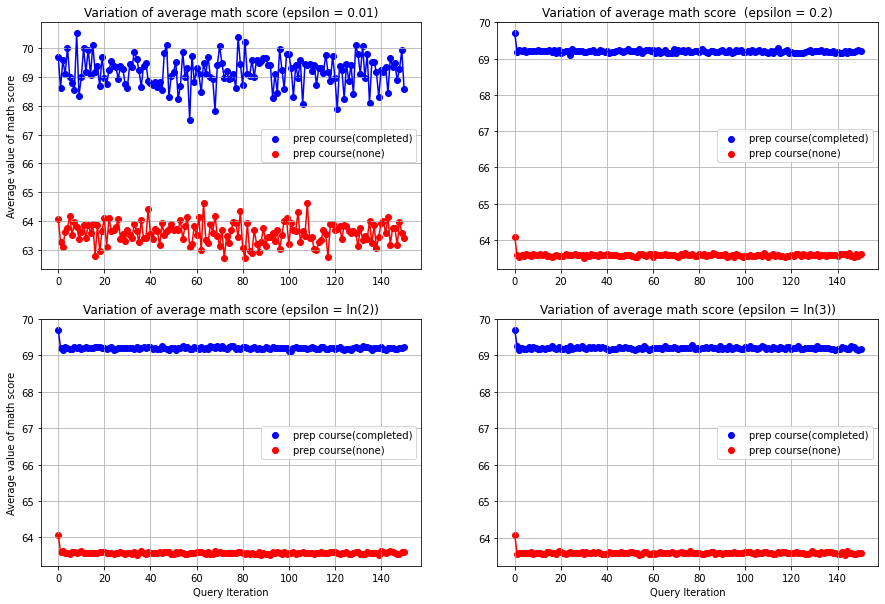

In [290]:
numQueries = 150
group = 'prep course'
queryType ='avg'
groupTypes = ['completed','none']
attr = 'math score'

figName = 'queries_'+queryType+'_'+group+'_'+attr
queries0_0_1, queries0_2,queriesln_2,queriesln_3 = queryVariation(numQueries,group,groupTypes,queryType,attr)

plotDatas = {'0.01': queries0_0_1, '0.2': queries0_2, 'ln(2)': queriesln_2, 'ln(3)': queriesln_3}

x = range(numQueries+1)

plotQueryVariation(x,plotDatas,group,groupTypes,attr,figName)

<Figure size 432x288 with 0 Axes>

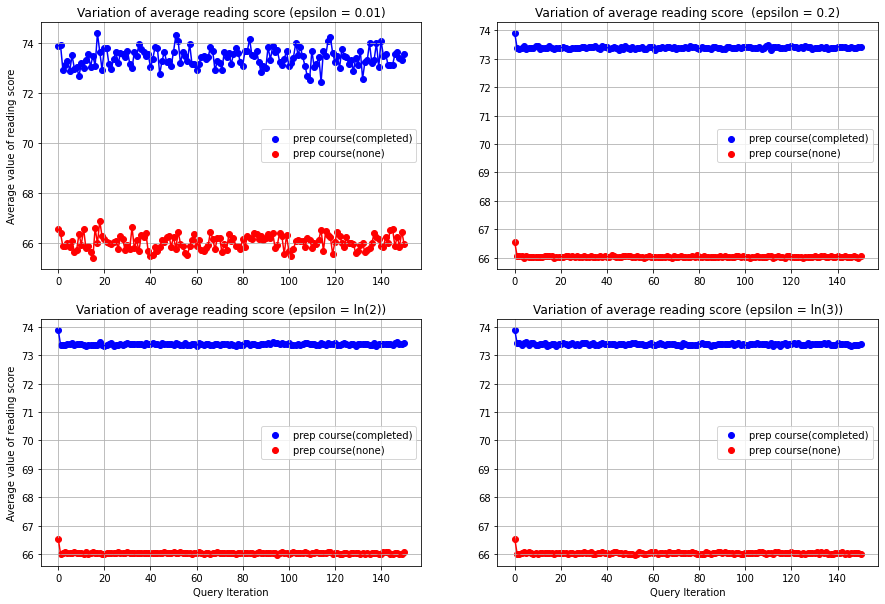

In [291]:
attr = 'reading score'
figName = 'queries_'+queryType+'_'+group+'_'+attr

queries0_0_1, queries0_2,queriesln_2,queriesln_3 = queryVariation(numQueries,group,groupTypes,queryType,attr)

plotDatas = {'0.01': queries0_0_1, '0.2': queries0_2, 'ln(2)': queriesln_2, 'ln(3)': queriesln_3}

x = range(numQueries+1)

plotQueryVariation(x,plotDatas,group,groupTypes,attr,figName)


<Figure size 432x288 with 0 Axes>

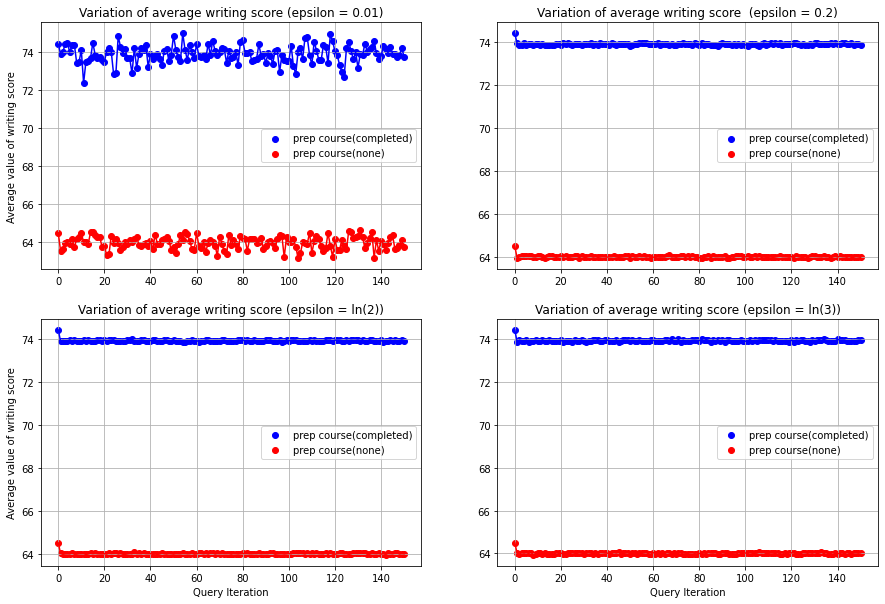

In [292]:
attr = 'writing score'
figName = 'queries_'+queryType+'_'+group+'_'+attr

queries0_0_1, queries0_2,queriesln_2,queriesln_3 = queryVariation(numQueries,group,groupTypes,queryType,attr)

plotDatas = {'0.01': queries0_0_1, '0.2': queries0_2, 'ln(2)': queriesln_2, 'ln(3)': queriesln_3}

x = range(numQueries+1)

plotQueryVariation(x,plotDatas,group,groupTypes,attr,figName)


EXERCISE 2.5 - Discuss advantages and disadvantages.

Advantages:

    - A liberdade de escolha de definição do nível de noise que é adicionado aos atributos sensíveis (valor de ɛ), possibilita o aumento ou diminuição da privacidade dos dados
    - A privacidade diferencial ajusta automaticamente a exactidão dos resultados da query, dando resultados tão exactos quanto possível ao mesmo tempo que mantém a privacidade.Desde que as queries não representem qualquer ameaça à privacidade, um sistema diferencialmente privado pode fornecer resultados bastante exactos.
    - É possível calcular a perda de privacidade da realização de duas análises diferencialmente privadas sobre os mesmos dados através da soma das perdas de privacidade individuais para duas análises.

Disadvantages:

    - O cálculo da sensitividade dos dados com a aplicação posterior da differential privacy leva a ter um custo computacional muito elevado
    - Quando há diversidade nos dados, inclui demasiado ruído o que acaba por reduzir a utilidade dos dados.

